In [42]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import numpy as np
import math

In [43]:
#units in kA, kV, MW, MVA,MVar,Euro

Time_day=96

s_trafo = 0.23*0.16*3 #data from DACS area7

#network
network=pd.read_csv("data\\network.csv")
connect1=pd.read_excel("data\\user_connect.xlsx")
user_index=connect1["Node"].tolist()
n_bus=len(network)+1
n_user= len(user_index)  #in DACS7, last one's load is 0 

#pv
pv_cap=connect1["PV"]*1E-3 #pv capacity from dacs data
pv_cap=pv_cap.tolist()

#hp
hp_own=connect1["HP"].tolist()
pf = 0.92 # baseload & HP
tan_phi_load = (np.sqrt(1-pf**2))/pf
p_hp_max=4.5*1e-3  #4.5kw
p_hp_min =1e-3 #1kw
#cost set
c_loss = 40
c_grid = 500
c_hp_down = 200
c_pv = 400

#pv constrain
pf_pv_limit = 0.95
tan_phi_pv = (np.sqrt(1-pf_pv_limit**2))/pf_pv_limit


#voltage constrain
v_ref = 0.23 # kV
v_lb = 0.96 #pu
v_ub = 1.04
#power

df=pd.read_csv("data\\UserPower.csv",index_col=0)
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y %I:%M %p')
# Filter for rows where the date is February 1, 2024
filtered_df = df[df['time'].dt.date == pd.to_datetime("2024-02-01").date()]
LoadPower=filtered_df.copy()
LoadPower= LoadPower.reset_index(drop=True)
LoadPower.index += 1
#reactive power
df=pd.read_csv("data\\UserReactivePower.csv",index_col=0)
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y %I:%M %p')
filtered_df = df[df['time'].dt.date == pd.to_datetime("2024-02-01").date()]
LoadReact=filtered_df.copy()
LoadReact= LoadReact.reset_index(drop=True)
LoadReact.index += 1

#pv efficiency data in "2024-02-01"

hourly_data = [
    0, 0, 0, 0, 0, 0, 0, 0, 0.006, 0.053, 0.129, 0.179,
    0.166, 0.14, 0.094, 0.046, 0.007, 0, 0, 0, 0, 0, 0, 0
]

expanded_data = [value for value in hourly_data for _ in range(4)]
expanded_df = pd.DataFrame(expanded_data, columns=["Quarter_Hourly_Data"])

#congestion set
congestion_limit=np.ones(96)*(-50*1e-3)# define the limit, -50 is no limit
#for a congestion test
for t in range(40,48):
    congestion_limit[t]=-15*1e-3

In [44]:
m = gp.Model("GEC")
m.Params.LogToConsole = 0
# define variables
p = m.addVars(n_bus,Time_day, lb = -float('inf'), vtype = GRB.CONTINUOUS, name = "PBusInjection")

q = m.addVars(n_bus, Time_day,lb = -float('inf'),  vtype = GRB.CONTINUOUS, name = "QBusInjection")

PLine = m.addVars(n_bus-1,Time_day, lb = -float('inf'),  vtype = GRB.CONTINUOUS, name = "PLine")
QLine = m.addVars(n_bus-1,Time_day, lb = -float('inf'),  vtype = GRB.CONTINUOUS, name = "QLine")
v = m.addVars(n_bus, Time_day,lb = (v_lb*v_ref)**2, ub = (v_ub*v_ref)**2, vtype = GRB.CONTINUOUS, name = "VoltSquare")
l = m.addVars(n_bus-1, Time_day,lb = 0, vtype = GRB.CONTINUOUS, name = "CurrentSquare")
p_pv = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "PVactivePower")
q_pv = m.addVars(n_user,Time_day, lb = -float('inf'),  vtype = GRB.CONTINUOUS, name = "PVreactivePower")

p_hp = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "HPactivePower")
q_hp = m.addVars(n_user,Time_day, lb = 0,  vtype = GRB.CONTINUOUS, name = "HPreactivePower")

p_pv_down = m.addVars(n_user,Time_day, lb = 0,  vtype = GRB.CONTINUOUS, name = "PVcurtailedActivePower")
b_hp =m.addVars(n_user,Time_day,  vtype = GRB.BINARY, name = "HP_Open")
p_hp_down = m.addVars(n_user,Time_day, lb = 0, vtype = GRB.CONTINUOUS, name = "HPcurtailedActivePower")




In [45]:
# define constraints

for t in range(Time_day):
        #choose the time
    run_time=t
    # pv efficiency in selected time
    pv_ef=expanded_df.at[run_time,"Quarter_Hourly_Data"]
    # load in selected time
    p_baseload=LoadPower.iloc[run_time,1:]*1E-3
    p_baseload=p_baseload.tolist()   
    q_baseload=LoadReact.iloc[run_time,1:]*1E-3
    q_baseload=q_baseload.tolist()
    
    # for slack bus, power balance
    m.addQConstr(p[0,t] >= congestion_limit[t], "TransPowerLimitForCongestion")
    m.addQConstr(p[0,t]*p[0,t] + q[0,t]*q[0,t]  <= s_trafo**2, "trafoLimit") # transformer loading constraints, #1 additional constraint
    
    # for non-slack bus, power balance
    for j in range(0,n_bus):
        P_outFlow = 0
        P_inFlow = 0
        P_loss=0
        for i in range(0,n_bus-1):
            if (network.at[i,'StartNode'] == j) :                
                P_outFlow += PLine[i,t]
            if (network.at[i,'EndNode'] == j) :                
                P_inFlow += PLine[i,t]
                P_loss += l[i,t]*network.at[i,'R']
        m.addConstr(p[j,t] == P_inFlow - P_loss - P_outFlow ,name = "BusPower{}".format(j))       
        
    for j in range(0,n_bus):
        Q_outFlow = 0
        Q_inFlow = 0
        Q_loss = 0
        for i in range(0,n_bus-1):
            if (network.at[i,'StartNode'] == j):    
                Q_outFlow += QLine[i,t]
            if (network.at[i,'EndNode'] == j):                
                Q_inFlow += QLine[i,t]
                Q_loss += l[i,t]*network.at[i,'X']
        m.addConstr(1E3*(q[j,t]  ) == -1E3*Q_outFlow + 1E3*(Q_inFlow-Q_loss) ,name = "BusReact{}".format(j))

        
    # voltage relation
    for i in range(n_bus-1):
        m.addConstr(1E5*v[network.at[i,'EndNode'],t] == 1E5*v[network.at[i,'StartNode'],t]\
                    -1E5*2*(network.at[i,'R']*PLine[i,t] \
                        +network.at[i,'X']*QLine[i,t])+1E5*(network.at[i,'R']**2+network.at[i,'X']**2)*l[i,t],name = "LineVoltage{}".format(i))
    
    for i in range(n_bus-1):
        m.addQConstr(1E3*PLine[i,t] * PLine[i,t] +1E3*QLine[i,t] * QLine[i,t] <=1E3* l[i,t] * v[network.at[i,'StartNode'],t], name = "BusSOCP{}".format(i))
    
    for i in range(n_bus-1):
            m.addConstr(1E3*l[i,t]  <= 1E3*(network.at[i,'Inom'])**2,name = "LineCurrent{}".format(i))
    m.addConstr(v[0,t] == v_ref**2,"transVol") #3 additional constraint
    # load constraints
    for i in range(n_bus):
        if i not in user_index and i != 0: # slack bus + residential loads
            m.addConstr(p[i,t] == 0,"busP=0")
            m.addConstr(q[i,t] == 0,"busQ=0")
        if i in user_index:
            m.addConstr(p[i,t] ==  p_baseload[i-(n_bus-n_user)] - p_pv[i-(n_bus-n_user),t] + p_hp[i-(n_bus-n_user),t], "LoadP")
            m.addConstr(q[i,t] ==  q_baseload[i-(n_bus-n_user)]  - q_pv[i-(n_bus-n_user),t] + q_hp[i-(n_bus-n_user),t], "LoadQ")          
    
    #constraints for pv hp
    for i in range(n_user):        
        m.addConstr(-p_pv[i,t] * tan_phi_pv <= q_pv[i,t],"pv_tan-")
        m.addConstr(q_pv[i,t] <= p_pv[i,t] * tan_phi_pv,"pv_tan+")
        m.addConstr(p_pv[i,t] <= pv_cap[i]*pv_ef,"pvMax")
        m.addConstr(p_pv_down[i,t] == pv_cap[i]*pv_ef - p_pv[i,t],"pv_down")
        
        m.addConstr(p_hp[i,t] <= b_hp[i,t]*p_hp_max*hp_own[i],"hp_max")
        m.addConstr(p_hp[i,t] >= b_hp[i,t]*p_hp_min*hp_own[i],"hp_min")
        m.addConstr(p_hp_down[i,t] >= p_hp_max*hp_own[i] - p_hp[i,t],"hp_down")
        m.addConstr(q_hp[i,t] == p_hp[i,t] * tan_phi_load,"hp_tan")
         


In [46]:
# define objective
obj = quicksum(l[i,t]*network.at[i,'R'] * c_loss for t in range(Time_day) for i in range(n_bus-1))\
+ quicksum(c_pv*p_pv_down[i,t] for t in range(Time_day) for i in range(n_user))\
+ quicksum(c_hp_down*p_hp_down[i,t] for t in range(Time_day) for i in range(n_user))\


# m.write("model.lp")
m.setObjective(1E3*obj, GRB.MINIMIZE)

In [47]:
m.optimize()
print(f"Optimization Runtime: {m.Runtime} seconds")
if m.status == GRB.OPTIMAL:
    print("Model solved successfully!")
    # m.write("opf_model.sol")
else:
    print(f"Model status: {m.status}")


Optimization Runtime: 101.95300006866455 seconds
Model solved successfully!


In [49]:
#change the output name
dict_optimizedResults = {
    "p": [[p[i,t].X  for t in range(Time_day)]for i in range(n_bus)],
    "q": [[q[i,t].X  for t in range(Time_day)] for i in range(n_bus)], 
    "v_value": [[v[i,t].X  for t in range(Time_day)] for i in range(n_bus)],   
    "p_hp_down": [[p_hp_down[i,t].X for t in range(Time_day)]for i in range(n_user)], 
    "p_hp": [[p_hp[i,t].X for t in range(Time_day)]for i in range(n_user)],
    "p_pv_down": [[p_pv_down[i,t].X for t in range(Time_day)]for i in range(n_user)], 
    "p_pv": [[p_pv[i,t].X for t in range(Time_day)]for i in range(n_user)],
    } 
# print(dict_optimizedResults)
Result_p = dict_optimizedResults["p"]
Result_q = dict_optimizedResults["q"]
Result_v= dict_optimizedResults["v_value"]
Result_hp_down = dict_optimizedResults["p_hp_down"]
Result_hp = dict_optimizedResults["p_hp"]
Result_pv_down = dict_optimizedResults["p_pv_down"]
Result_pv = dict_optimizedResults["p_pv"]


In [50]:
Result_hp_array = np.array(Result_hp)
Result_hp_sum = Result_hp_array.sum(axis=0)*1e3  

Result_hp_down_array = np.array(Result_hp_down)
Result_hp_down_sum = Result_hp_down_array.sum(axis=0)*1e3  

Result_pv_array = np.array(Result_pv)
Result_pv_sum = Result_pv_array.sum(axis=0)*1e3  

Result_pv_down_array = np.array(Result_pv_down)
Result_pv_down_sum = Result_pv_down_array.sum(axis=0)*1e3  


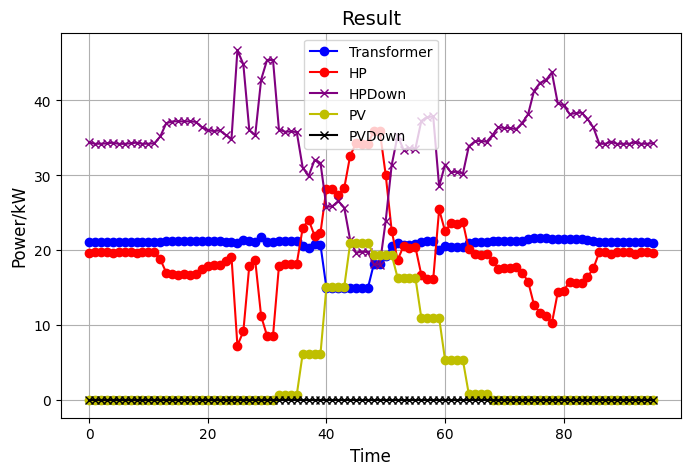

In [52]:
import matplotlib.pyplot as plt
# Create an index for the x-axis
indices = range(len(Result_p[0]))
transformed_Result_p = [-val * 1e3 for val in Result_p[0]]
# Plot the data
plt.figure(figsize=(8, 5))
plt.plot(indices, transformed_Result_p, marker='o', linestyle='-', color='b', label='Transformer')
plt.plot(Result_hp_sum, label="HP", marker='o', color='r')
plt.plot(Result_hp_down_sum, label="HPDown", marker='x', color='purple')  
plt.plot(Result_pv_sum, label="PV", marker='o', color='y')
plt.plot(Result_pv_down_sum, label="PVDown", marker='x', color='black') 


# Add labels and title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power/kW', fontsize=12)
plt.title('Result', fontsize=14)
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
#thermal model

#house parameter
#total thermal output
# Q_thermal= Qhp+Qcv
# Qhp=Php*COP   
#C_house*(T_in(t)-T_in(t-1)) = Q_thermal*dt+(T_amb-T_in(t-1))/R_house*dt

# I want to have the T_in and the correspoding model. so I can use T_in to get PMV and thus get the constraints of heat demand

#thermal uncomfort
# PPD=F(T_in(t))
